# Modelling twinning crystal reorientations

The reorientation caused by twinning is modeled as a rotation by $60^\circ$ about $<1\, 1\, 1\,>$. This is implemented using quaternion algebra.

We first import the usual modules plus an `orientation` helper module for calculation orientation matrices and plotting pole figures and a `quat` module for quaternion rotations.   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import orientations as ori
from quat import Quat

## Twinning using quaternion rotations

Quaternion algebra is used to "rotate" the parent crystal into all the symmetrical equivalent rotations:

In [20]:
def twin_ori(phi1, Phi, phi2):
    ''' Takes three euler angles (in degrees and  returns all twinn variants as 
    a list of matrices, g_list and a list of euler angles, euler_list '''
    axis_list=ori.get_pole_list('111')
    parent_ori= ori.euler_to_quat(phi1,Phi,phi2)
    g_list=[]
    euler_list=[]
    for twin_axis in axis_list:
        twinOriCalc = ori.twinOrientation(parent_ori,twin_axis)
        euler= np.degrees(twinOriCalc.eulerAngles())
        euler_list.append(euler)
        g=ori.ori_matrix(euler[0],euler[1],euler[2])
        g_list.append(g)
        # plt.figure()
        # plot_all_poles(g,proj='equal area')    
    return g_list, euler_list

With a starting orientation given by: $\phi_1 = 10.0 $, $\Phi = 0.0 $ and $\phi_2 = 0.0$:

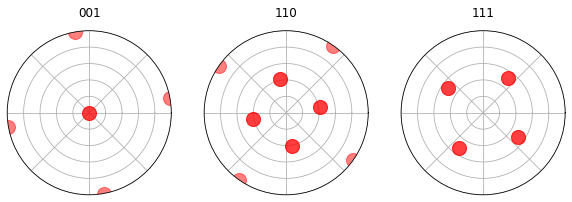

In [3]:
g=ori.ori_matrix(10.0,0.0,0.0)
ori.plot_all_poles(g)

The twinning rotations produce the following pole figures:

In [4]:
g_list, euler_list = twin_ori(10.0, 0.0, 0.0)

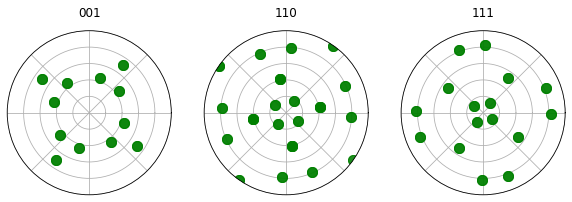

In [5]:
ori.plot_all_poles_multi(g_list)

The pole figures are clearly very different from those measured experimentally. A closer match can be achieved by twinning the twinned orientations, i.e. by double twinning. The function below rotates all the reorientations produced by the first twinning operation, using the same twinning "rotation". 

In [6]:
def double_twin(phi1,Phi, phi2):
    g_list, euler_list = twin_ori(phi1, Phi, phi2)
    euler_list3 = []
    g_list3 = []
    for euler in euler_list:
        phi1 = euler[0]
        Phi = euler[1]
        phi2 = euler[2]
        g_list2, euler_list2 = twin_ori(phi1, Phi, phi2)
        euler_list3 = euler_list3+euler_list2
        g_list3 = g_list3+g_list2
    return g_list3, euler_list3 

In [7]:
g_list_double, euler_list_double = double_twin(10.0, 0.0, 0.0)

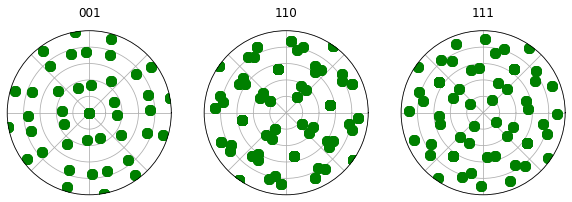

In [8]:
ori.plot_all_poles_multi(g_list_double, proj = 'equal area')

This produces pole figures which are more similar to those seen experimentally, with the exception of variants produced by reversing the original twin (like the one at the centre of the 001 pole figure), which do not exist. These can be removed from the plot:

In [9]:
def twin_ori_double(phi1, Phi, phi2):
    axis_list=ori.get_pole_list('111')
    parent_ori=ori.euler_to_quat(phi1,Phi,phi2)
    g_list=[]
    euler_list=[]
    for twin_axis in axis_list:
        twinOriCalc = ori.twinOrientation(parent_ori,twin_axis)
        for twin_axis2 in axis_list:
            if ((np.sum(twin_axis2+twin_axis) != 0) 
                and (twin_axis2 != twin_axis).any()):
                dtwinOriCalc = ori.twinOrientation(twinOriCalc,twin_axis2)
                euler= np.degrees(dtwinOriCalc.eulerAngles())
                euler_list.append(euler)
                g=ori.ori_matrix(euler[0],euler[1],euler[2])
                g_list.append(g)   
    return g_list, euler_list

In [10]:
g_list_d, euler_list_d = twin_ori_double(0.0, 0.0, 0.0)

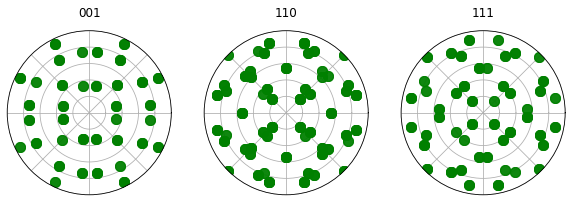

In [11]:
ori.plot_all_poles_multi(g_list_d, proj = 'equal area')

## Article figure 9

In the article we simulate double twinning for the orientation studied using the ETMT, shown in figure 9.

The parent orientation:

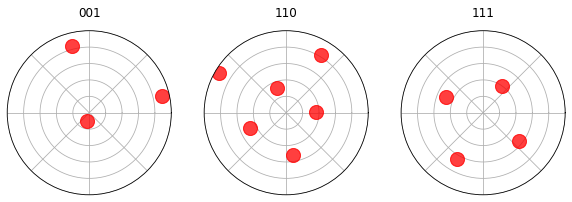

In [12]:
g=ori.ori_matrix(344.3, 11.6, 29.6)
ori.plot_all_poles(g)

One variant:

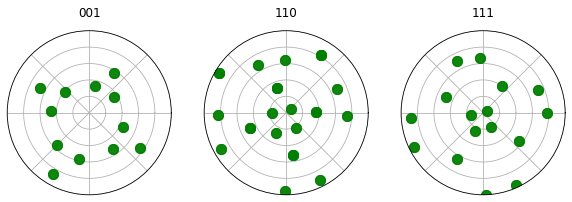

In [13]:
g_list, euler_list = twin_ori(344.3, 11.6, 29.6)
ori.plot_all_poles_multi(g_list)

Double twinning:

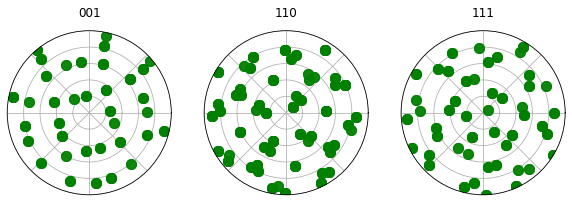

In [17]:
g_list_d, euler_list_d = twin_ori_double(344.3, 11.6, 29.6)
ori.plot_all_poles_multi(g_list_d, proj = 'equal area')

We can then use these function to produce figure 9 in the article:

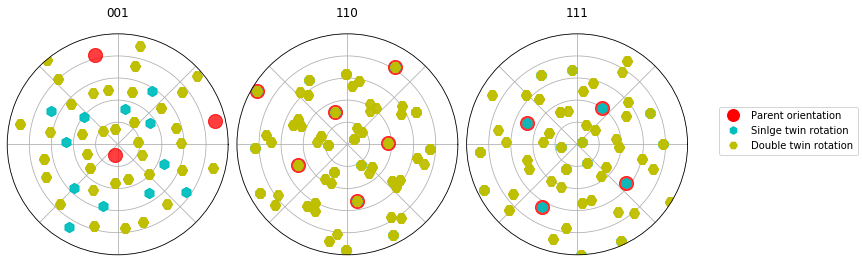

In [18]:
f=plt.figure(figsize=(12,4))
g=ori.ori_matrix(344.3, 11.6, 29.6)
ori.plot_all_poles(g, fig = f,label ='ro')
g_list, euler_list = twin_ori(344.3, 11.6, 29.6)
ori.plot_all_poles_multi(g_list, fig=f,label ='ch')
g_list_d, euler_list_d_ = twin_ori_double(344.3, 11.6, 29.6)
ori.plot_all_poles_multi(g_list_d, fig = f, label = 'yH')
from matplotlib.lines import Line2D

legend_elements= [Line2D([0], [0], marker='o', color='w', label='Parent orientation',
                          markerfacecolor='r', markersize=14),
                 Line2D([0], [0], marker='h', color='w', label='Sinlge twin rotation',
                          markerfacecolor='c', markersize=10),
                 Line2D([0], [0], marker='H', color='w', label='Double twin rotation',
                          markerfacecolor='y', markersize=10)]
f.legend(handles=legend_elements, loc = 'center right')
f.tight_layout()
f.subplots_adjust(right=0.8)

In [19]:
f.savefig('twin_model.png', dpi = 300)